<h1>Hypothesis</h1>
<h3> The population and density can affect to the AQI index of a city</h3>

<h3>Read the AQI Data and Calculate Average, Min, Max AQI of each city</h3>

In [363]:
# Read AQI Data, calculate average AQI in a week
# Read Population Data, Area Data, Make density 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [364]:
# Read AQ
def average_AQI(file=''):
    df = pd.read_csv(file)
    df = df[['city','AQI']]
    df_result = df.groupby('city').mean()
    df_result.columns = ['avg_AQI']
    return df_result
# Read AQ
def max_AQI(file=''):
    df = pd.read_csv(file)
    df = df[['city','AQI']]
    df_result = df.groupby('city').max()
    df_result.columns = ['max_AQI']
    return df_result

def min_AQI(file=''):
    df = pd.read_csv(file)
    df = df[['city','AQI']]
    df_result = df.groupby('city').min()
    df_result.columns = ['min_AQI']
    return df_result

In [365]:
df_avg_aqi = average_AQI('../ProcessedAQI/Final/aqi.csv')
df_max_aqi = max_AQI('../ProcessedAQI/Final/aqi.csv')
df_min_aqi = min_AQI('../ProcessedAQI/Final/aqi.csv')
print(df_avg_aqi)

                       avg_AQI
city                          
Abeokuta             71.500000
Abidjan              64.583333
Abu Dhabi            84.512658
Abuja                88.750000
Acapulco de Juarez   70.546053
...                        ...
Zhaoqing             94.105263
Zhengzhou           166.096386
Zhenjiang Jiangsu   163.550633
Zhoushan             52.955696
Zurich               23.817610

[711 rows x 1 columns]


In [366]:
df = pd.merge(df_avg_aqi, df_max_aqi, on="city")
df = pd.merge(df, df_min_aqi, on="city")
df_aqi = pd.DataFrame(df)
df_aqi

,avg_AQI,max_AQI,min_AQI
city,,,
Abeokuta,71.500000,91.0,36.0
Abidjan,64.583333,96.0,51.0
Abu Dhabi,84.512658,132.0,53.0
Abuja,88.750000,126.0,68.0
Acapulco de Juarez,70.546053,167.0,36.0
...,...,...,...
Zhaoqing,94.105263,131.0,55.0
Zhengzhou,166.096386,263.0,106.0
Zhenjiang Jiangsu,163.550633,192.0,130.0


In [367]:
# Check type of each attribute
print(df_aqi.dtypes)

avg_AQI    float64
max_AQI    float64
min_AQI    float64
dtype: object


In [368]:
# Check if average,max,min AQI dataframe contains null value
print("AQI:\n",df_aqi.isna().sum())


AQI:
 avg_AQI    0
max_AQI    0
min_AQI    0
dtype: int64


<h3>Read the Population Data and Area Data to generate the Density of each city</h3>

In [369]:
# Read Population + Area to a DataFrame
import pandasql as ps
def population_area(population_path='',area_path=''):
    df_population = pd.read_csv(population_path)
    df_population = df_population[['Name','Population','Country']].drop_duplicates()
    df_area = pd.read_csv(area_path)
    df_area = df_area[['city','area']].drop_duplicates()
    # print(len(df_area))
    # print(len(df_population['Name'].unique()))
    for index,row in df_area.iterrows():
        row['area'] = row['area'].replace('.','')
        row['area'] = float(row['area'])
        # print(row['area'])
    sql1 = "SELECT df_area.city,df_population.population,df_population.Country,df_area.area, df_population.population*1.0/df_area.area as density FROM df_area,df_population  WHERE df_area.city == df_population.Name"
    df_result = ps.sqldf(sql1,locals())
    return df_result


In [370]:
df_density = population_area('../data/population.csv','../data/area.csv')
df_density = df_density.drop_duplicates()
print(len(df_density['city'].unique()))
# df_density.to_csv('./aqi_density.csv')
df_density.dtypes


730


city           object
Population      int64
Country        object
area          float64
density       float64
dtype: object

In [371]:
df_density.isna().sum()

city          0
Population    0
Country       0
area          0
density       0
dtype: int64

<h3>Join 2 Tables: AQI and Density</h3>

In [372]:
# Create AQI + Density DataFrame
sql = 'SELECT df_aqi.city,Country,avg_AQI,max_AQI,min_AQI,Population,area,density FROM df_aqi,df_density WHERE df_aqi.city = df_density.city'
df2_avg = ps.sqldf(sql,locals())
df2 = df2_avg.drop_duplicates(subset='city', keep="first")
df2.to_csv('./aqi_density.csv')

In [373]:
print(df2)
print(df2.dtypes)

            city        Country     avg_AQI  max_AQI  min_AQI  Population  \
0          Tokyo          Japan   59.913043    126.0     24.0    37339804   
1          Delhi          India  205.879518    329.0     63.0    31181376   
2       Shanghai          China  113.939759    212.0     56.0    27795702   
3      Sao Paulo         Brazil   72.716867    212.0     54.0    22237472   
4    Mexico City         Mexico  121.436364    222.0     54.0    21918936   
..           ...            ...         ...      ...      ...         ...   
712       Arusha       Tanzania   87.200000     98.0     66.0      504857   
713       Murcia          Spain   31.592308     81.0     14.0      504491   
714       Tirana        Albania   40.335821     87.0     15.0      502734   
715  Surat Thani       Thailand   87.400000    154.0     30.0      502564   
716  Kansas City  United States   55.637037    115.0     23.0      501957   

        area       density  
0     6276.0   5949.618228  
1     1484.0  210

In [374]:
minvalue_series = df2.min(skipna = False)
maxvalue_series = df2.max(skipna = False)
print(minvalue_series)
print(maxvalue_series)

city             Abeokuta
Country       Afghanistan
avg_AQI              21.3
max_AQI              26.0
min_AQI               2.0
Population         501957
area                 19.0
density          0.070537
dtype: object
city                Zurich
Country           Zimbabwe
avg_AQI         222.118012
max_AQI              500.0
min_AQI              181.0
Population        37339804
area            17130000.0
density       85697.829596
dtype: object


<h4>Nhận định chung về dữ liệu</h4>
<p> Các trường dữ liệu: <br/>
    - avg_AQI: float -  [21.3, 222.118012] <br/>
    - max_AQI : float -  [26.0, 500] <br/>
    - min_AQI: float -  [2.0, 181.0] <br/>
    - Population: int -  [501957, 37339804] people <br/>
    - area: float -  [19.0, 17130000.0] km2 <br/>
    - density: float -  [0.070537, 85697.829596] people/km2 <br/>
</p>

<h3>Normalization</h3>

In [375]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
df1 = df2.copy()
# df2[['AQI','density']] = StandardScaler().fit_transform(df2[['AQI', 'density']])
df1[['avg_AQI','max_AQI','min_AQI','density','Population']] = MinMaxScaler().fit_transform(df1[['avg_AQI','max_AQI','min_AQI', 'density','Population']])


<h3>Visualization the Data</h3>

<h4>Plot number of cites according to level of AQI</h4>
<p>
    - 0-50: Good <br /> 
    - 50-100: Morderate <br /> 
    - 101-150: Unhealthy for Sensitive Groups <br /> 
    - 151-200: Unhealthy <br /> 
    - 201-300: Very Unhealthy <br /> 
    - 301 - Higher: Hazardous <br /> 
</p> 

In [376]:
# Make the Colormap according to AQI value
def cmap(list_value:list):
    color_map=[None] * len(list_value)
    i = 0
    for i in range(0,len(list_value)):
        if list_value[i]<51:
            color_map[i]='green'
        elif list_value[i] >= 51 and list_value[i]<101:
            color_map[i]='yellow'
        elif list_value[i] >= 101 and list_value[i]<151:
            color_map[i]='orange'
        elif list_value[i] >= 151 and list_value[i]<201:
            color_map[i]='red'
        elif list_value[i] >= 201 and list_value[i]<301:
            color_map[i]='purple'
        else:
            color_map[i]='maroon'
    return color_map



[]

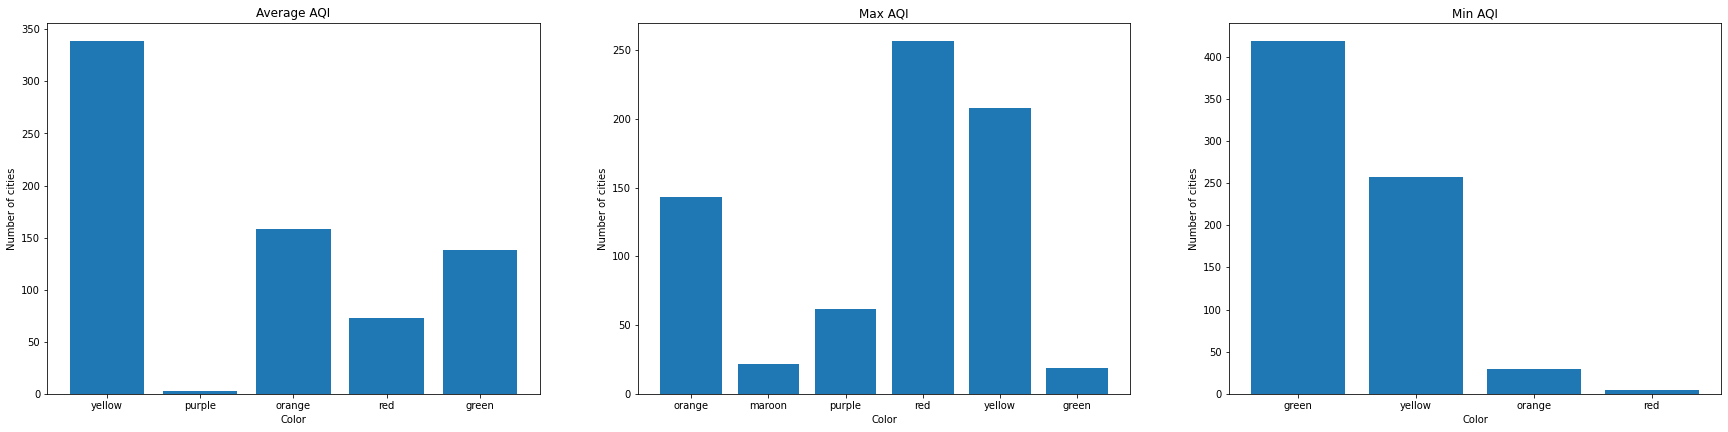

In [377]:
def get_barchart_statistic(cmap:list):
    d={}
    d = {x:cmap.count(x) for x in cmap}
    return d
fig = plt.figure(figsize = (30,15))

#### Subplot 1###

plt.subplot(2,3,1)
#Add titles to the chart and axes
plt.title('Average AQI')
plt.xlabel('Color')
y = df2['avg_AQI'].tolist()
c_map_avg =  cmap(y)
d1 = get_barchart_statistic(c_map_avg)

plt.bar(d1.keys(),d1.values())
plt.ylabel('Number of cities')

#### Subplot 2 ###

plt.subplot(2,3,2)
#Add titles to the chart and axes
plt.title('Max AQI')
plt.xlabel('Color')
plt.ylabel('Number of cities')
x = df2['density'].tolist()
y = df2['max_AQI'].tolist()

c_map_max =  cmap(y)
d2 = get_barchart_statistic(c_map_max)
plt.bar(d2.keys(),d2.values())

#### Subplot 2 ###

plt.subplot(2,3,3)
#Add titles to the chart and axes
plt.title('Min AQI')
plt.xlabel('Color')
plt.ylabel('Number of cities')
x = df2['density'].tolist()
y = df2['min_AQI'].tolist()

c_map_min =  cmap(y)
d3 = get_barchart_statistic(c_map_min)
plt.bar(d3.keys(),d3.values())


plt.plot()

<p>Density and Average, Min, Max AQI </p>

[]

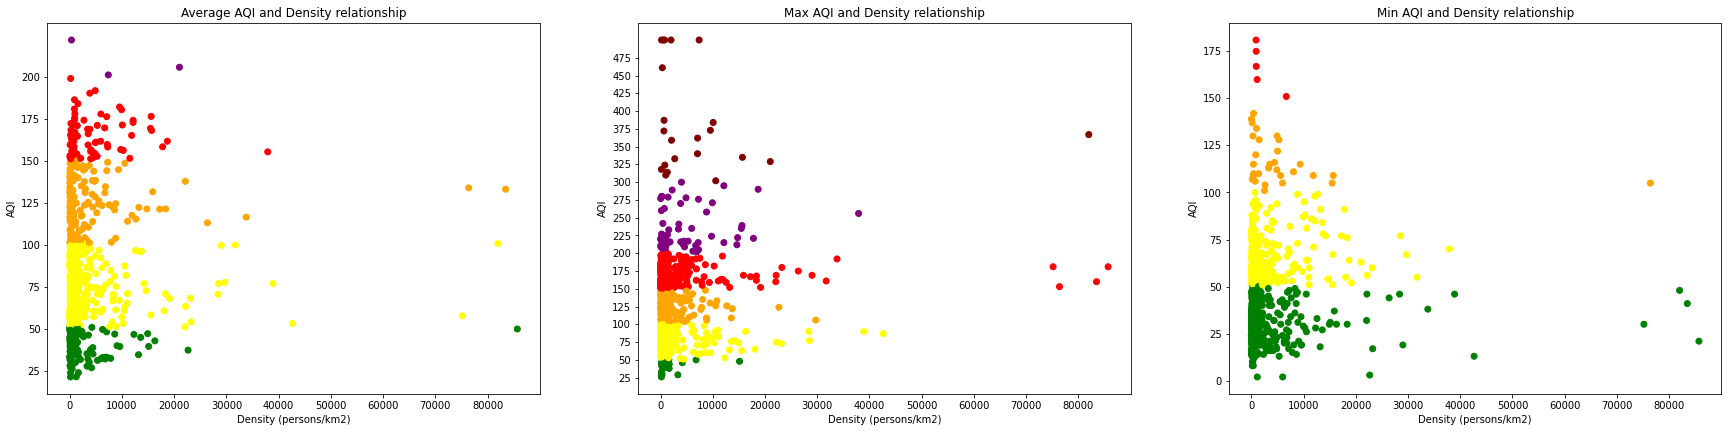

In [378]:
#Set the size of the matplotlib canvas
fig = plt.figure(figsize = (30,15))

#### Subplot 1###

plt.subplot(2,3,1)
#Add titles to the chart and axes
plt.title('Average AQI and Density relationship')
plt.ylabel('AQI')
plt.xlabel('Density (persons/km2)')
x = df2['density'].tolist()
y = df2['avg_AQI'].tolist()
c_map_avg =  cmap(y)
# print(c_map_avg)
plt.yticks(np.arange(0, max(y), 25))
plt.xticks(np.arange(0, max(x), 10000))
plt.scatter(x,y,c=c_map_avg)

#### Subplot 2 ###

plt.subplot(2,3,2)
#Add titles to the chart and axes
plt.title('Max AQI and Density relationship')
plt.ylabel('AQI')
plt.xlabel('Density (persons/km2)')

x = df2['density'].tolist()
y = df2['max_AQI'].tolist()
plt.yticks(np.arange(0, max(y), 25))
plt.xticks(np.arange(0, max(x), 10000))
c_map_max =  cmap(y)
plt.scatter(x,y,c=c_map_max)

#### Subplot 2 ###

plt.subplot(2,3,3)
#Add titles to the chart and axes
plt.title('Min AQI and Density relationship')
plt.ylabel('AQI')
plt.xlabel('Density (persons/km2)')

x = df2['density'].tolist()
y = df2['min_AQI'].tolist()
plt.yticks(np.arange(0, max(y), 25))
plt.xticks(np.arange(0, max(x), 10000))
c_map_min =  cmap(y)
plt.scatter(x,y,c=c_map_min)


plt.plot()



<p>Population and Average, Max, Min AQI </p>

[]

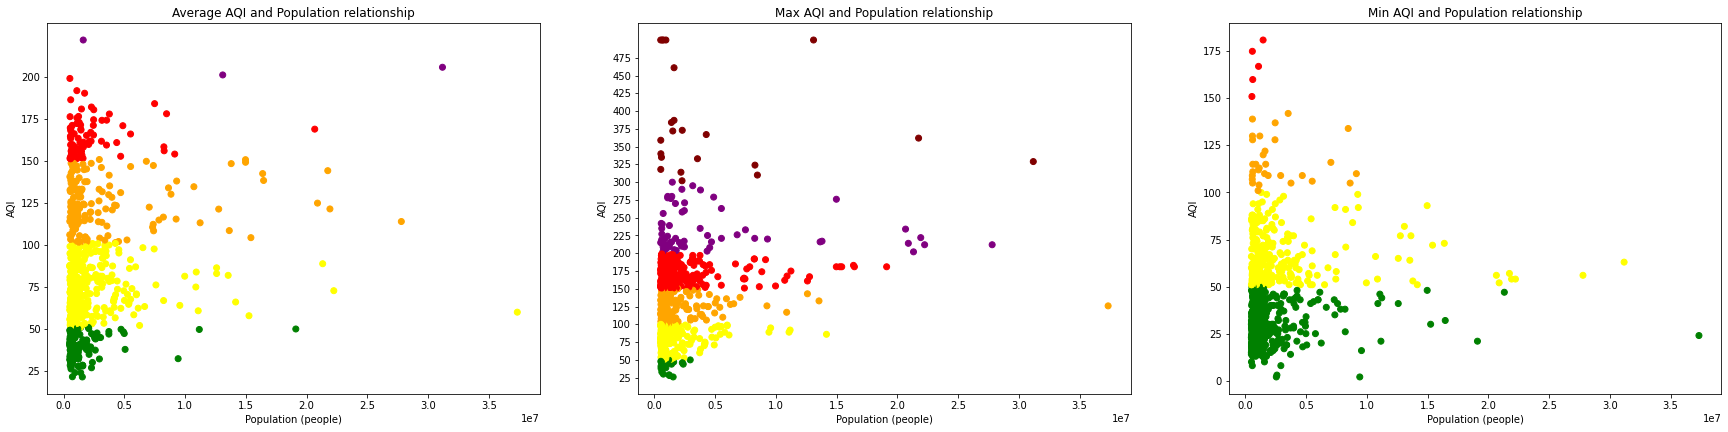

In [379]:
#Set the size of the matplotlib canvas
fig = plt.figure(figsize = (30,15))

#### Subplot 1###

plt.subplot(2,3,1)
#Add titles to the chart and axes
plt.title('Average AQI and Population relationship')
plt.ylabel('AQI')
plt.xlabel('Population (people)')
x = df2['Population'].tolist()
y = df2['avg_AQI'].tolist()
plt.yticks(np.arange(0, max(y), 25))
c_map_avg =  cmap(y)
plt.scatter(x,y,c=c_map_avg)


#### Subplot 2 ###

plt.subplot(2,3,2)
#Add titles to the chart and axes
plt.title('Max AQI and Population relationship')
plt.ylabel('AQI')
plt.xlabel('Population (people)')
x = df2['Population'].tolist()
y = df2['max_AQI'].tolist()
plt.yticks(np.arange(0, max(y), 25))
c_map_max =  cmap(y)
plt.scatter(x,y,c=c_map_max)

#### Subplot 2 ###

plt.subplot(2,3,3)
#Add titles to the chart and axes
plt.title('Min AQI and Population relationship')
plt.ylabel('AQI')
plt.xlabel('Population (people)')
x = df2['Population'].tolist()
y = df2['min_AQI'].tolist()
plt.yticks(np.arange(0, max(y), 25))
c_map_min =  cmap(y)
plt.scatter(x,y,c=c_map_min)

plt.plot()


<h3>Pearson Correlation Metric</h3>

In [380]:
# Pearson Correlation Metric
r = df1.corr(method ='pearson')
r

,avg_AQI,max_AQI,min_AQI,Population,area,density
avg_AQI,1.000000,0.746851,0.716507,0.172175,-0.051490,0.085984
max_AQI,0.746851,1.000000,0.376516,0.211114,-0.050223,0.109807
min_AQI,0.716507,0.376516,1.000000,0.111444,-0.043979,0.075721
Population,0.172175,0.211114,0.111444,1.000000,-0.012428,0.263092
area,-0.051490,-0.050223,-0.043979,-0.012428,1.000000,-0.019662
density,0.085984,0.109807,0.075721,0.263092,-0.019662,1.000000


<p> Nhận định đưa ra: <br/>
    - Population ảnh hưởng đến các chỉ số về AQI do Pearson Correlation > 0 <br/>
    - Density ảnh hưởng đến các chỉ số về AQI do Pearson Correlation > 0, Tuy nhiên thấp hơn so với Population <br/>
    - area không ảnh hưởng đến các chỉ số về AQI do Pearson Correlation <0><br/>
</p>